In [1]:
import torch
from ROOT import TMVA, TFile, TTree, TCut, gROOT, gPad, TCanvas
from os.path import isfile

In module 'Darwin':
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/libkern/arm/OSByteOrder.h:14:1: error: '_OSSwapInt16' has different definitions in different modules; definition in module 'Darwin.libkern.OSByteOrder' first difference is return type is 'uint16_t' (aka 'unsigned short')
uint16_t
^~~~~~~~
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/libkern/arm/_OSByteOrder.h:49:1: note: but in 'DarwinFoundation.OSByteOrder' found different return type '__uint16_t' (aka 'unsigned short')
__uint16_t
^~~~~~~~~~
In module 'Darwin':
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/libkern/arm/OSByteOrder.h:24:1: error: '_OSSwapInt32' has different definitions in different modules; definition in module 'Darwin.libkern.OSByteOrder' first difference is return type is 'uint32_t' (aka 'unsigned int')
uint32_t
^~~~~~~~
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/libkern/arm/_OSByteOrder.h:59:1: note: but in 'DarwinFoundation.O

Welcome to JupyROOT 6.30/04


In [2]:
# Setup TMVA
TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize()

# create factory
outputFile = TFile.Open('dataset/rootFile/TMVA.root', 'RECREATE')
factory = TMVA.Factory('TMVAClassification',outputFile,
    '!V:!Silent:Color:DrawProgressBar:Transformations=D,G:AnalysisType=multiclass')

In [3]:
keys = [
    "bbgg_mass",
    "dibjet_pt",
    "diphoton_pt",
    "bbgg_pt",
    "bbgg_eta",
    "bbgg_phi",
    "lead_pho_eta",
    "lead_pho_phi",
    "sublead_pho_eta",
    "sublead_pho_phi",
    "diphoton_eta",
    "diphoton_phi",
    "dibjet_eta",
    "dibjet_phi",
    "sublead_bjet_pt",
    "lead_bjet_phi",
    "sublead_bjet_eta",
    "sublead_bjet_phi",
    "sublead_bjet_PNetB",
    "lead_bjet_PNetB",
    "CosThetaStar_gg",
    "CosThetaStar_jj",
    "CosThetaStar_CS",
    "DeltaR_jg_min",
    "pholead_PtOverM",
    "phosublead_PtOverM",
    "FirstJet_PtOverM",
    "SecondJet_PtOverM",
    "diphoton_bbgg_mass",
    "dibjet_bbgg_mass",
]

In [4]:
# Load data
data = TFile.Open('../../outputfiles/hhbbgg_analyzer-trees.root')
signal = data.Get('GluGluToHH/preselection')
backgrounds = [
    data.Get("GGJets/preselection"),
    data.Get("GJetPt20To40/preselection"),
    data.Get("GJetPt40/preselection"),
]
dataloader = TMVA.DataLoader('dataset')
for key in keys:
    dataloader.AddVariable(key)

dataloader.AddSignalTree(signal, 1.0)
dataloader.SetSignalWeightExpression("weight_preselection")

for background in backgrounds:
    dataloader.AddBackgroundTree(background, 1.0)
dataloader.PrepareTrainingAndTestTree(
    TCut(""),
    "nTrain_Signal=10000:nTrain_Background=10000:SplitMode=Random:NormMode=NumEvents:!V",
)
dataloader.SetBackgroundWeightExpression("weight_preselection")


DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree preselection of type Signal with 131972 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree preselection of type Background with 46802 events
                         : Add Tree preselection of type Background with 9867 events
                         : Add Tree preselection of type Background with 41966 events
                         : Dataset[dataset] : Class index : 0  name : Signal
                         : Dataset[dataset] : Class index : 1  name : Background


In [5]:
# Define model
model = torch.nn.Sequential()
model.add_module('linear_1', torch.nn.Linear(in_features=len(keys), out_features=64))
model.add_module('relu', torch.nn.ReLU())
model.add_module('linear_2', torch.nn.Linear(in_features=64, out_features=2))
model.add_module('softmax', torch.nn.Softmax(dim=1))


In [6]:
# Set loss and optimizer
loss = torch.nn.CrossEntropyLoss()
# loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD

In [7]:
# Define train function
def train(model, train_loader, val_loader, num_epochs, batch_size, optimizer, criterion, save_best, scheduler):
    trainer = optimizer(model.parameters(), lr=0.01)
    schedule, schedulerSteps = scheduler
    best_val = None

    for epoch in range(num_epochs):
        # Training Loop
        # Set to train mode
        model.train()
        running_train_loss = 0.0
        running_val_loss = 0.0
        for i, (X, y) in enumerate(train_loader):
            trainer.zero_grad()
            output = model(X)
            target = torch.max(y, 1)[1]
            train_loss = criterion(output, target)
            train_loss.backward()
            trainer.step()

            # print train statistics
            running_train_loss += train_loss.item()
            if i % 32 == 31:    # print every 32 mini-batches
                print("[{}, {}] train loss: {:.3f}".format(epoch+1, i+1, running_train_loss / 32))
                running_train_loss = 0.0

        if schedule:
            schedule(optimizer, epoch, schedulerSteps)

        # Validation Loop
        # Set to eval mode
        model.eval()
        with torch.no_grad():
            for i, (X, y) in enumerate(val_loader):
                output = model(X)
                target = torch.max(y, 1)[1]
                val_loss = criterion(output, target)
                running_val_loss += val_loss.item()

            curr_val = running_val_loss / len(val_loader)
            if save_best:
               if best_val==None:
                   best_val = curr_val
               best_val = save_best(model, curr_val, best_val)

            # print val statistics per epoch
            print("[{}] val loss: {:.3f}".format(epoch+1, curr_val))
            running_val_loss = 0.0

    print("Finished Training on {} Epochs!".format(epoch+1))

    return model

In [8]:
# Define predict function
def predict(model, test_X, batch_size=32):
    # Set to eval mode
    model.eval()

    test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_X))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    predictions = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            X = data[0]
            outputs = model(X)
            predictions.append(outputs)
        preds = torch.cat(predictions)

    return preds.numpy()


In [9]:
load_model_custom_objects = {"optimizer": optimizer, "criterion": loss, "train_func": train, "predict_func": predict}

In [10]:
# Store model to file
# Convert the model to torchscript before saving
m = torch.jit.script(model)
torch.jit.save(m, "modelFile/modelMultiClass.pt")
print(m)


RecursiveScriptModule(
  original_name=Sequential
  (linear_1): RecursiveScriptModule(original_name=Linear)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (linear_2): RecursiveScriptModule(original_name=Linear)
  (softmax): RecursiveScriptModule(original_name=Softmax)
)


In [11]:
# Book methods
factory.BookMethod(dataloader, TMVA.Types.kPyTorch, "PyTorch",
        'H:!V:VarTransform=D,G:FilenameModel=modelFile/modelMultiClass.pt:FilenameTrainedModel=modelFile/trainedModelMultiClass.pt:NumEpochs=20:BatchSize=32')


custom objects for loading model :  {'optimizer': <class 'torch.optim.sgd.SGD'>, 'criterion': CrossEntropyLoss(), 'train_func': <function train at 0x3092fb760>, 'predict_func': <function predict at 0x3092fbbe0>}


Factory                  : Booking method: PyTorch
                         : 
PyTorch                  : [dataset] : Create Transformation "D" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'bbgg_mass' <---> Output : variable 'bbgg_mass'
                         : Input : variable 'dibjet_pt' <---> Output : variable 'dibjet_pt'
                         : Input : variable 'diphoton_pt' <---> Output : variable 'diphoton_pt'
                         : Input : variable 'bbgg_pt' <---> Output : variable 'bbgg_pt'
                         : Input : variable 'bbgg_eta' <---> Output : variable 'bbgg_eta'
                         : Input : variable 'bbgg_phi' <---> Output : variable 'bbgg_phi'
                         : Input : variable 'lead_pho_eta' <---> Output : variable 'lead_pho_eta'
                         : Input : variable 'lead_pho_phi' <---> Output : variable 'lea

In [12]:
# Run TMVA
factory.TrainAllMethods()
factory.TestAllMethods()
factory.EvaluateAllMethods()

RecursiveScriptModule(
  original_name=Sequential
  (linear_1): RecursiveScriptModule(original_name=Linear)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (linear_2): RecursiveScriptModule(original_name=Linear)
  (softmax): RecursiveScriptModule(original_name=Softmax)
)
[1, 32] train loss: 0.697
[1, 64] train loss: 0.686
[1, 96] train loss: 0.683
[1, 128] train loss: 0.674
[1, 160] train loss: 0.662
[1, 192] train loss: 0.654
[1, 224] train loss: 0.649
[1, 256] train loss: 0.641
[1, 288] train loss: 0.631
[1, 320] train loss: 0.621
[1, 352] train loss: 0.619
[1, 384] train loss: 0.607
[1, 416] train loss: 0.599
[1, 448] train loss: 0.593
[1, 480] train loss: 0.590
[1] val loss: 0.578
[2, 32] train loss: 0.570
[2, 64] train loss: 0.565
[2, 96] train loss: 0.560
[2, 128] train loss: 0.550
[2, 160] train loss: 0.540
[2, 192] train loss: 0.538
[2, 224] train loss: 0.529
[2, 256] train loss: 0.521
[2, 288] train loss: 0.516
[2, 320] train loss: 0.506
[2, 352] train loss: 0.506
[2, 38

0%, time left: unknown
7%, time left: 1 sec
13%, time left: 1 sec
19%, time left: 1 sec
25%, time left: 1 sec
32%, time left: 1 sec
38%, time left: 1 sec
44%, time left: 1 sec
50%, time left: 0 sec
56%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
81%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 16 sec
13%, time left: 14 sec
19%, time left: 13 sec
25%, time left: 12 sec
32%, time left: 11 sec
38%, time left: 10 sec
44%, time left: 9 sec
50%, time left: 8 sec
57%, time left: 7 sec
63%, time left: 6 sec
69%, time left: 5 sec
75%, time left: 4 sec
82%, time left: 3 sec
88%, time left: 2 sec
94%, time left: 1 sec


Info in <TCanvas::Print>: png file dataset/plots/ROC_MulticlassPyTorch.png has been created
Info in <TCanvas::Print>: pdf file dataset/plots/ROC_MulticlassPyTorch.pdf has been created


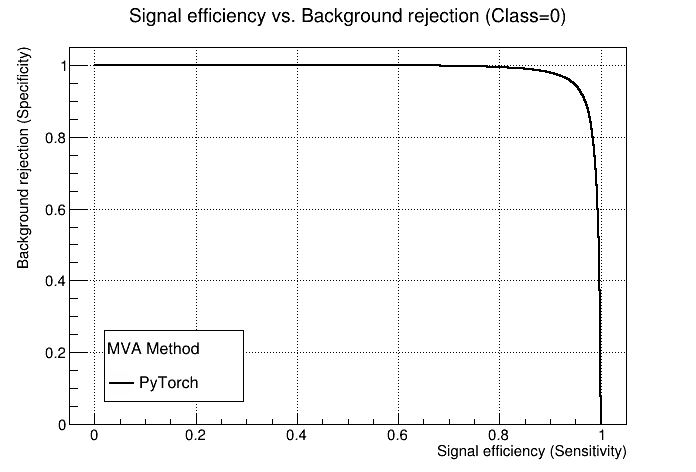

In [13]:
# Plot ROC Curves
roc = factory.GetROCCurve(dataloader)
roc.SaveAs('dataset/plots/ROC_MulticlassPyTorch.png')
roc.SaveAs('dataset/plots/ROC_MulticlassPyTorch.pdf')
outputFile.Close()

Info in <TCanvas::Print>: png file dataset/plots/CorrelationMatrixSignal.png has been created
Info in <TCanvas::Print>: pdf file dataset/plots/CorrelationMatrixSignal.pdf has been created
Info in <TCanvas::Print>: png file dataset/plots/CorrelationMatrixBackground.png has been created
Info in <TCanvas::Print>: pdf file dataset/plots/CorrelationMatrixBackground.pdf has been created


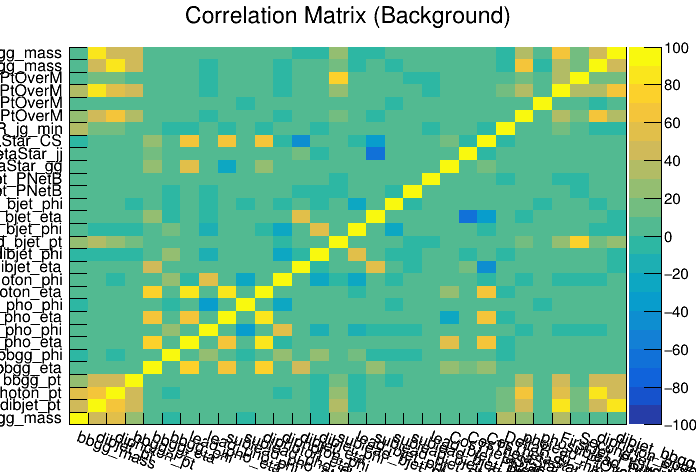

In [14]:
canvas = TCanvas()
correlation_matrix_signal = dataloader.GetCorrelationMatrix("Signal")
correlation_matrix_signal.Draw("COLZ")
canvas.SaveAs("dataset/plots/CorrelationMatrixSignal.png")
canvas.SaveAs("dataset/plots/CorrelationMatrixSignal.pdf")

correlation_matrix_background = dataloader.GetCorrelationMatrix("Background")
correlation_matrix_background.Draw("COLZ")
canvas.SaveAs("dataset/plots/CorrelationMatrixBackground.png")
canvas.SaveAs("dataset/plots/CorrelationMatrixBackground.pdf")


Info in <TCanvas::Print>: png file dataset/plots/CorrelationMatrixSignal.png has been created
Info in <TCanvas::Print>: pdf file dataset/plots/CorrelationMatrixSignal.pdf has been created
Info in <TCanvas::Print>: png file dataset/plots/CorrelationMatrixBackground.png has been created
Info in <TCanvas::Print>: pdf file dataset/plots/CorrelationMatrixBackground.pdf has been created


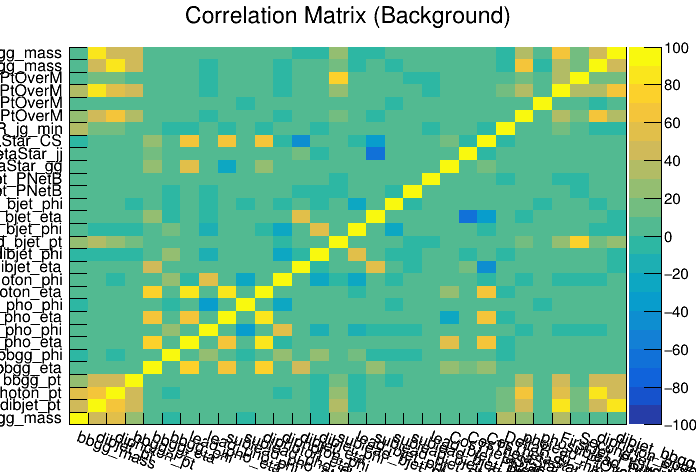

In [15]:
canvas = TCanvas()
correlation_matrix_signal = dataloader.GetCorrelationMatrix("Signal")
correlation_matrix_signal.Draw("COLZ")
canvas.SaveAs("dataset/plots/CorrelationMatrixSignal.png")
canvas.SaveAs("dataset/plots/CorrelationMatrixSignal.pdf")

correlation_matrix_background = dataloader.GetCorrelationMatrix("Background")
correlation_matrix_background.Draw("COLZ")
canvas.SaveAs("dataset/plots/CorrelationMatrixBackground.png")
canvas.SaveAs("dataset/plots/CorrelationMatrixBackground.pdf")


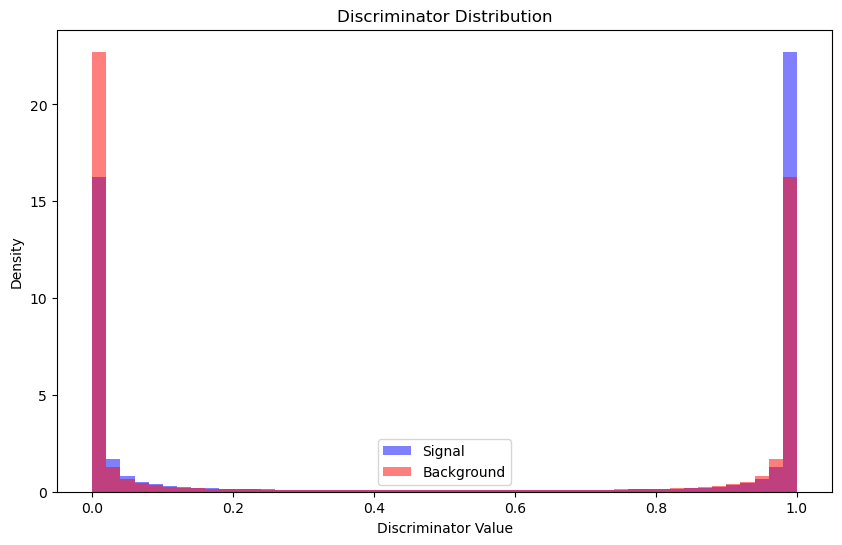

In [16]:
import uproot
import matplotlib.pyplot as plt
import numpy as np

# Example code to read data using uproot
# Replace these paths with the paths to your ROOT files and tree names
tmva_file = uproot.open('dataset/rootFile/TMVA.root')
tree_name = tmva_file['dataset/TestTree']["PyTorch"].arrays()


# Convert to numpy arrays if needed
signal_discriminators = tree_name['PyTorch']['Signal']
background_discriminators = tree_name['PyTorch']['Background']

# Plotting
plt.figure(figsize=(10, 6))

# Plot histogram for signal discriminators
plt.hist(signal_discriminators, bins=50, alpha=0.5, label='Signal', color='blue', density=True)

# Plot histogram for background discriminators
plt.hist(background_discriminators, bins=50, alpha=0.5, label='Background', color='red', density=True)

# Add labels and legend
plt.xlabel('Discriminator Value')
plt.ylabel('Density')
plt.title('Discriminator Distribution')
plt.legend()

# Show plot
plt.savefig("dataset/plots/Discriminator.pdf")
plt.savefig("dataset/plots/Discriminator.png")